In [1]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
import statsmodels.tsa.vector_ar.var_model as VAR
from datetime import datetime
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Load data

In [13]:
a=load_daily_volume()

In [17]:
mkts=a.columns

In [19]:
a=[1234,12,4,2,5]

In [36]:
a.append(4)


In [37]:
a



[2, 4, 5, 12, 1234, 4, 4, 4, 4, 4]

In [22]:
a_sorted=a.sort()
a_sorted


In [2]:
cleansed=load_amihud_markets_price()

tsmom_model.py:146: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:148: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud = \frac{|r_t|}{\text{volume}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


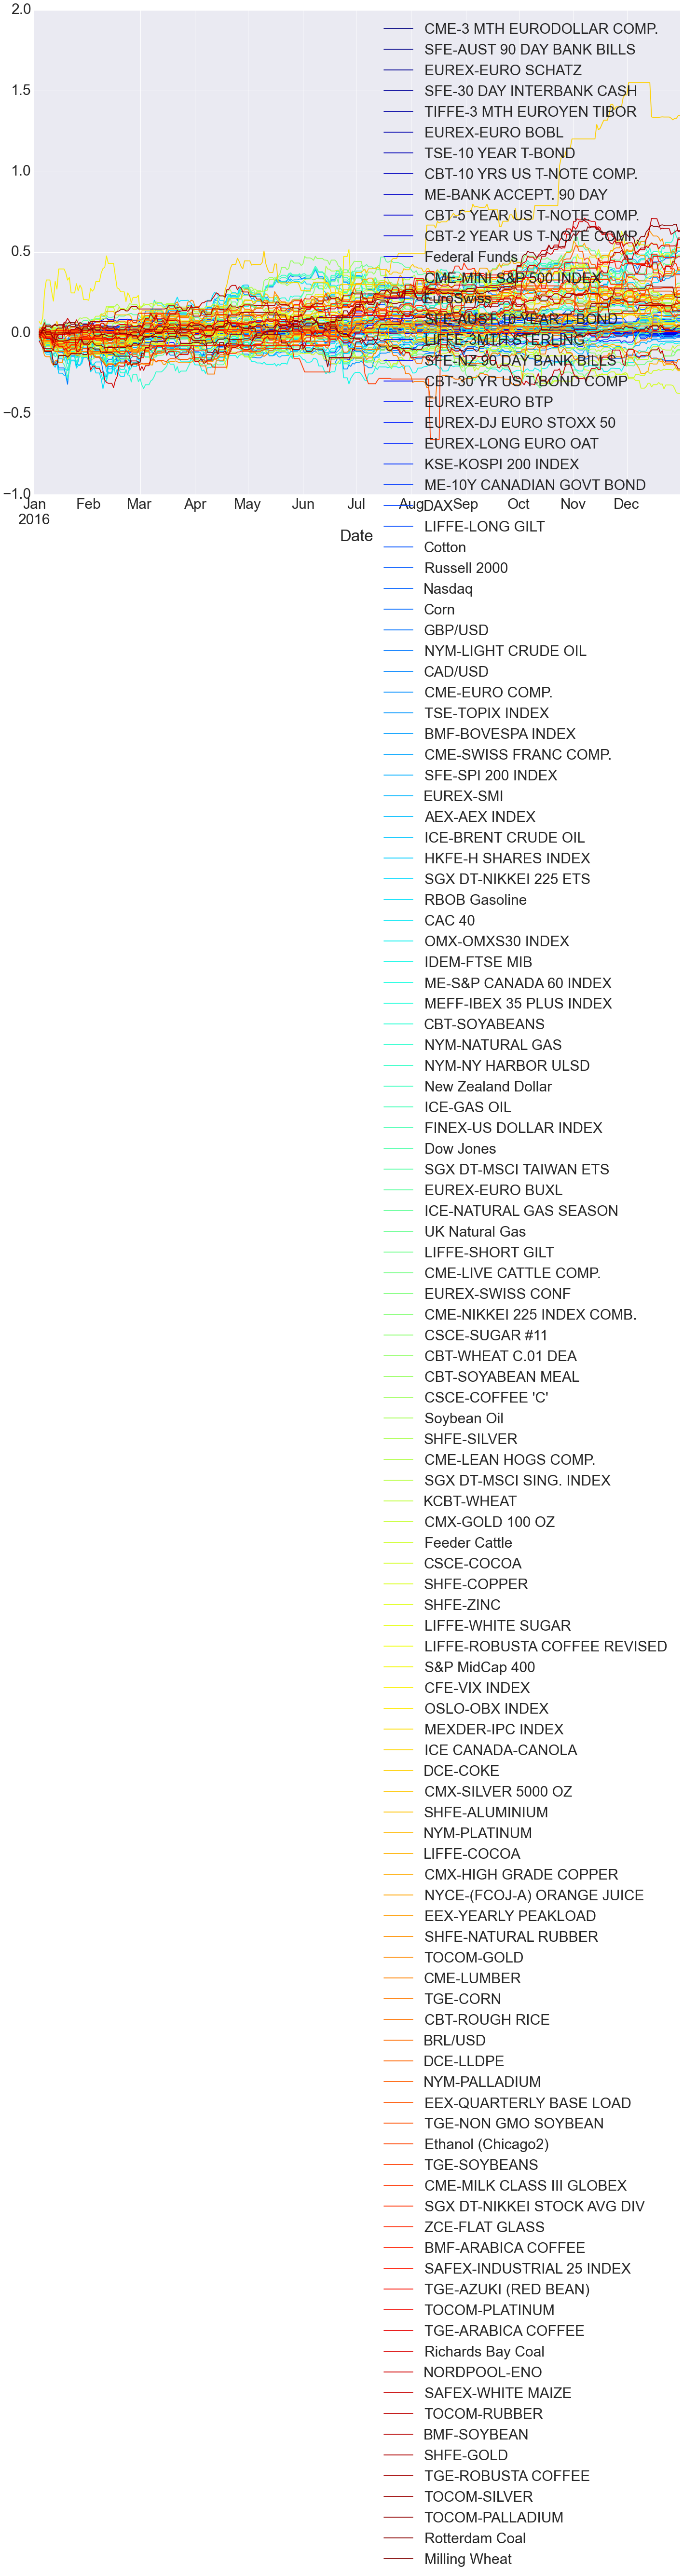

In [9]:
cleansed['2016'].pct_change().cumsum().ffill().plot(colormap='jet')

In [3]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:33: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:36: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future versio

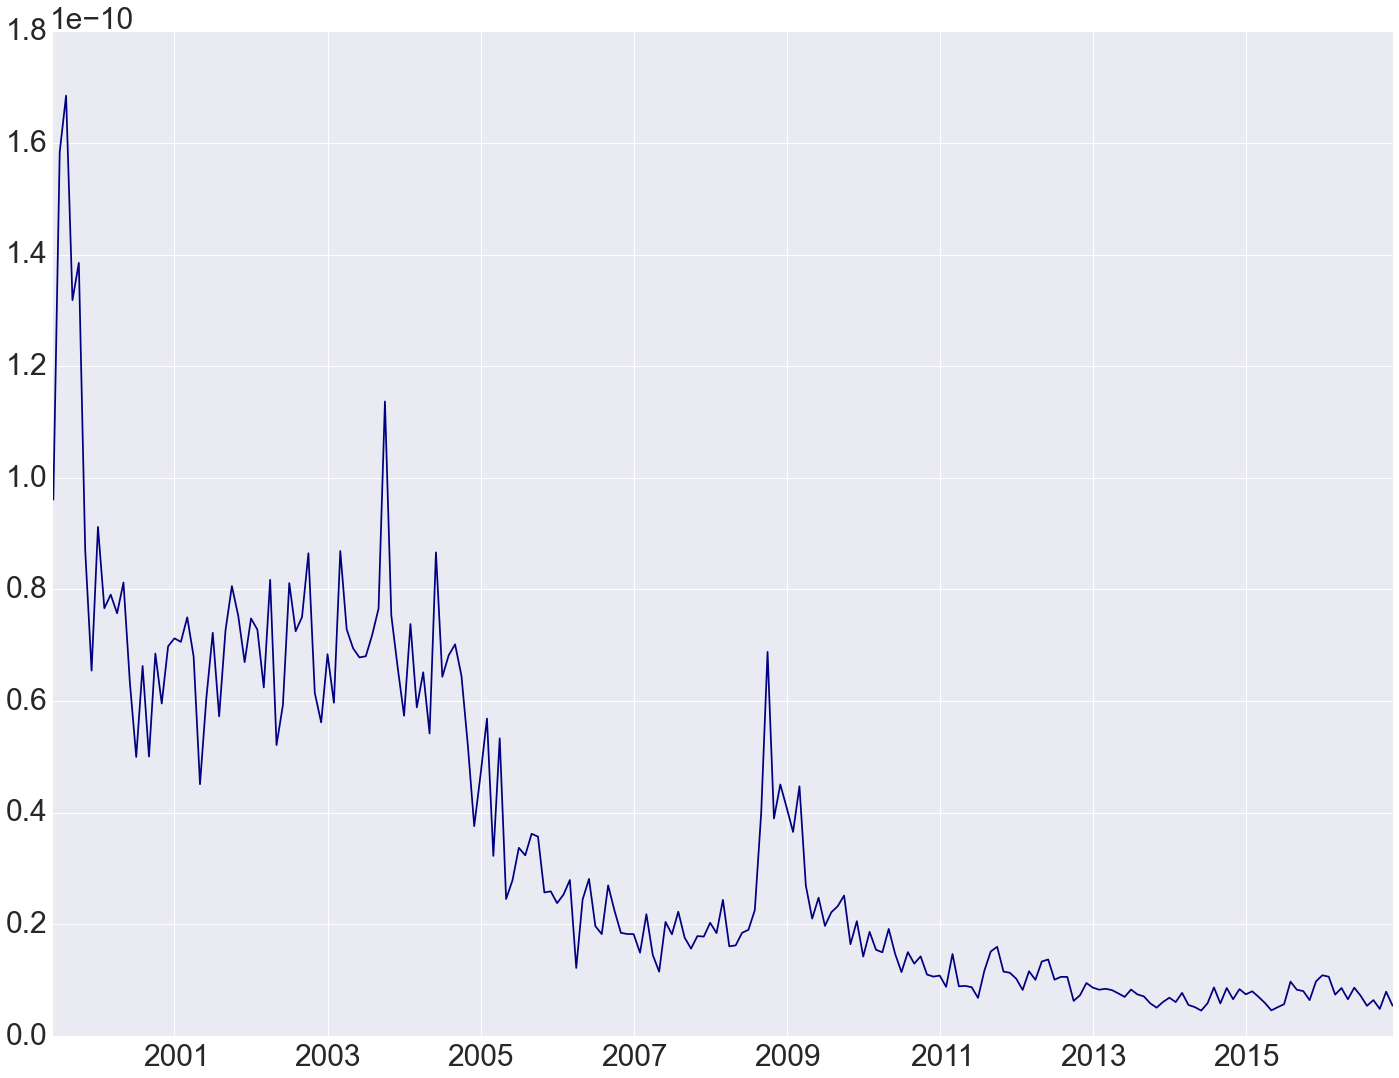

In [4]:
amihud.median(axis=1).dropna().plot(colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


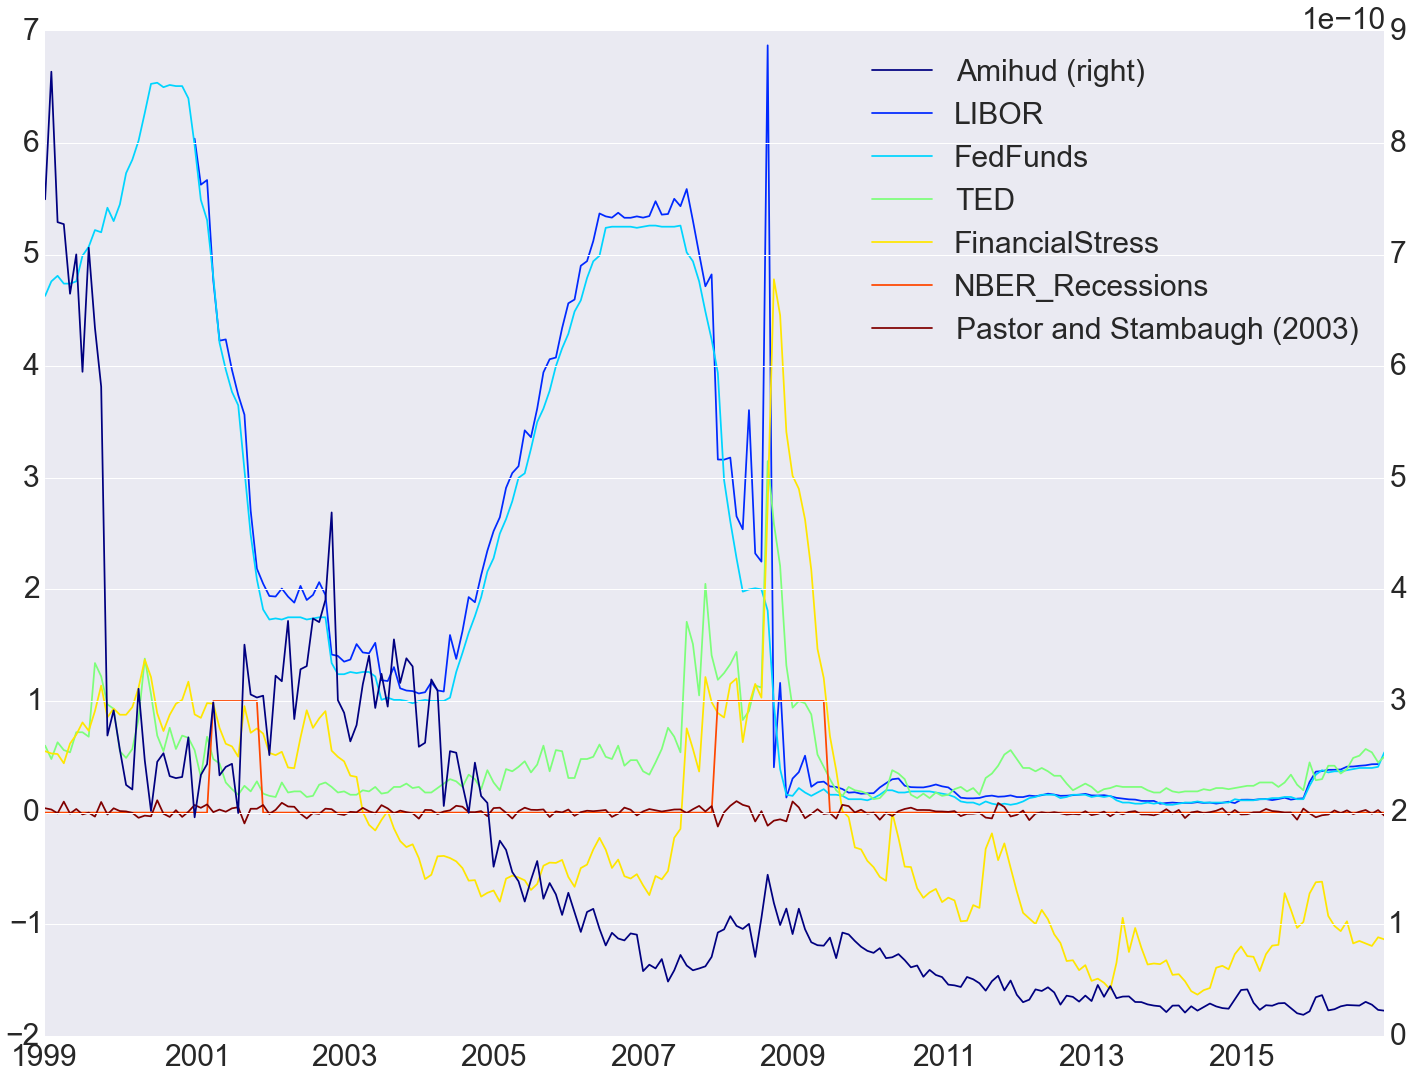

In [5]:
PS=pd.read_csv('PS.csv',parse_dates=[0]).set_index('Month').resample(rule='m',how='last')
factors=pd.read_csv('market_liquidity_factors.csv',index_col=0,parse_dates=[0])
factors['Pastor and Stambaugh (2003)']=PS['Traded liquidity factor']
factors.plot(secondary_y='Amihud',colormap='jet')

In [6]:
central_banks_asset=pd.DataFrame()
central_banks_asset['ECB']=pd.read_csv('ECBASSETS.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).ECBASSETS.resample(rule='m',how='last')
central_banks_asset['BOJ']=pd.read_csv('JPNASSETS.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).JPNASSETS.resample(rule='m',how='last') 
central_banks_asset['Fed']=pd.read_csv('WALCL.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).WALCL.resample(rule='m',how='last')
fx=pd.DataFrame()
fx['BOJ']=quandl.get('CURRFX/USDJPY',authtoken=token).resample(rule='m',how='last').Rate/100
fx['ECB']=quandl.get('CURRFX/USDEUR',authtoken=token).resample(rule='m',how='last').Rate
fx['Fed']=1


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

In [ ]:
(central_banks_asset/fx).dropna(how='all').sum(axis=1).plot()

In [ ]:
factors['Central Bank Assets']=(central_banks_asset/fx).dropna(how='all').sum(axis=1).resample(rule='m',how='last')

In [ ]:
factors['Amihud']=np.log(amihud.median(axis=1).dropna())

I need to understand what the VAR should look like.  Previously I used something that looked like this:

$$ X_t = \mu + \Phi X_{t-1} - \Sigma \varepsilon_t $$

But what is X in this case?

In [ ]:
factors.columns

In [ ]:

col=[u'Amihud', u'LIBOR', u'FinancialStress','Central Bank Assets']

In [ ]:
factors.plot(colormap='jet',secondary_y='Amihud')

In [ ]:
res = VAR.VAR(endog=factors[col].dropna()).fit()
print res.summary()

In [ ]:
df=pd.DataFrame()
df['Values']=res.params.Amihud
df['Tstat']=res.tvalues.Amihud

In [ ]:
df

In [ ]:
x=res.params.Amihud

In [ ]:
y=pd.DataFrame()
y['Results']=res.params.Amihud.append(res.tvalues.Amihud)

In [ ]:
print y.round(2).to_latex()

In [ ]:
res = VAR.VAR(endog=factors[col].dropna()).fit(2)
print res.summary()

In [ ]:
res = VAR.VAR(endog=factors[col].dropna()).fit(5)
print res.summary()

In [ ]:
sns.heatmap(pd.DataFrame(res.resid_corr,index=col,columns=col),annot=True)

In [ ]:
print pd.DataFrame(res.resid_corr,index=col,columns=col).round(2).to_latex()

In [ ]:
model = VAR.VAR(endog=factors[col].dropna())

In [ ]:
model.select_order(14)

In [ ]:
resaic = model.fit(maxlags=5,ic='aic')
irf=resaic.irf(5)
sns.set(font_scale=1)
irf.plot()